In [2]:
import os
import sys
sys.path.append('models/')
sys.path.append('eval/')
sys.path.append('process_data/')

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import scipy
from scipy.stats import poisson, norm, laplace, lognorm

# custom GCNN classes
from class_dataset import CTA_Data
from class_gat_lstm import GAT_LSTM
from class_mve_loss import MVELoss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import util_gat, util_gcnn
import util_eval
import util_plot
from setup import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 11})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def post_process_dist(dist, loc, scale):
    
    if dist == "lognorm":
        out_predict = np.exp(loc - np.power(scale,2))
        out_std = np.mean(np.sqrt((np.exp(scale * scale)-1)*(np.exp(2*loc+scale * scale))))
    elif dist == 'tnorm':
        out_predict = loc
        out_std = np.mean(scale)
    elif dist == 'laplace':
        out_predict = loc
        out_std = np.mean(scale) * np.sqrt(2)
    elif dist == 'poisson':
        out_predict = loc
        out_std = np.mean(np.sqrt(loc))
    elif dist == 'norm':
        out_predict = loc
        out_std = np.mean(scale)        
        
    return out_predict, out_std
 
    
def post_process_pi(dist, loc, scale, z):
    
    if dist == "lognorm":
#         predict = np.exp(loc - np.power(scale,2))
#         lb = np.exp(predict - z*scale)
#         ub = np.exp(predict + z*scale)
        lb, ub = lognorm.interval(z, loc, scale)
    elif dist == 'tnorm':
#         lb = np.max([0, loc - z*scale])
#         ub = loc + z*scale
        lb, ub = norm.interval(z, loc, scale)
        lb = lb * (lb>0)
    elif dist == 'laplace':
#         predict = loc
#         lb = predict + scale * np.log(2*z)
#         ub = predict - scale * np.log(2-2*(1-z))
        lb, ub = laplace.interval(z, loc, scale)
    elif dist == 'poisson':
        predict = loc
        lb,ub = poisson.interval(z, loc) 
    elif dist == 'norm':
        lb, ub = norm.interval(z, loc, scale)
#         print(loc, scale, lb, ub)

    return lb, ub

def evaluate(args, dist, dataloader, z, y_eval):
    
    val_out_loc, val_out_scale, val_loss = util_gat.testset_output_gat(dataloader, args.MeanOnly, net, criterion, 
            adj_torch, spatial_torch, device, n_time)
    val_out_predict, val_out_std = post_process_dist(dist, val_out_loc, val_out_scale)

    val_mae, val_mse, _, _, _ = util_eval.eval_mean(val_out_predict, y_eval, "")

    if args.LossFunc == 'mve':
        lb, ub = post_process_pi(dist, val_out_loc, val_out_scale, z)
        val_mpiw, val_picp = util_eval.eval_pi(lb, ub, y_eval)
    else:
        val_mpiw = 0
        val_picp = 0
        
    return val_loss, val_mae, val_mse, val_mpiw, val_picp, val_out_std, np.mean(val_out_predict)


In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [13]:
project_dir = "/home/jtl/Dropbox (MIT)/project_uncertainty_quantification/"

# parser = argparse.ArgumentParser(fromfile_prefix_chars='@')

# parser.add_argument("-p", "--Period", help="Study period: before/after", type=str, default='before')    
# parser.add_argument("-ph", "--PredictHorizon", help="Predict horizon", default=1)
# parser.add_argument("-ts", "--TimeSize", help="Time aggregation", default=4)
# parser.add_argument("-df", "--Difference", help="Whether to difference", default=1)
# parser.add_argument("-l", "--Lookback", help="Lookback period", default=2)
# parser.add_argument("-a", "--Adj", help="Adjacency matrix type", default=["func","euc","con","net"])
# parser.add_argument("-d", "--Dist", help="Lognorm/Tnorm distribution", default='tnorm')
# parser.add_argument("-ls", "--LossFunc", help="Loss function mve/mse", default='mve')
# parser.add_argument("-m", "--MeanOnly", help="Whether to output mean only or mean+variance", default=0)
# parser.add_argument("-hm", "--Homoskedastic", help="Whether homo or hetero-skedastic variance is estimated", default=0)
# parser.add_argument("-te", "--TrainExtent", help="Training Extent: downtown/all", default='downtown')
# parser.add_argument("-e", "--Epoch", help="Number of training epochs", default=500)
# parser.add_argument("-lr", "--LearningRate", help="Learning rate", default=0.001)
# parser.add_argument("-ms", "--ModelNumberStart", help="Start number of models for each combination of the parameters", type=int, default=-1)
# parser.add_argument("-me", "--ModelNumberEnd", help="End number of models for each combination of the parameters", type=int, default=10)
# parser.add_argument("-s", "--IncludeSpatial", help="Whether to include spatial (demo+poi) information", default=0)
# parser.add_argument("-b", "--Bootstrap", help="Whether to bootstrap training data", default=0)
# parser.add_argument("-of", "--OutFolder", help="Output Folder", default="")
# parser.add_argument("-sv", "--Save", help="Whether to save models", default=0)

# args = parser.parse_args(['@arguments.txt'])

# args.Period = args.Period.split(',')
# args.Lookback = [int(x) for x in args.Lookback.split(',')]
# args.Dist = args.Dist.split(',')
# args.Difference = bool(int(args.Difference))
# args.MeanOnly = bool(int(args.MeanOnly))
# args.Homoskedastic = bool(int(args.Homoskedastic))
# args.IncludeSpatial = bool(int(args.IncludeSpatial))
# args.Save = bool(int(args.Save))
# args.Bootstrap = bool(int(args.Bootstrap))

args = dotdict({"Period": ['before'],
       "OutFolder":"220405",
       "Lookback":[2,4,6],
       "Dist":["norm"],
       "MeanOnly":False,
       "ModelNumberStart":0,
       "ModelNumberEnd":1,
       "Adj":["func","euc","con","net"],
       "Model":"GAT",
       "Save":False,
       "PredictHorizon":1,
       "TimeSize":4,
       "Difference":True,
       "LossFunc":"mve",
       "Homoskedastic":False,
       "TrainExtent":"downtown",
       "Epoch":501,
       "LearningRate":0.00005,
       "IncludeSpatial":False,
       "Bootstrap":False})

dropout_rate_list=[0.2,0.5]
n_hid_units_list=[64,128]
weight_decay_list = [0.0001, 0.001, 0.01, 0.1]
ngc_list = [1,2]
nlstm_list = [1,2]
hps = list(itertools.product(dropout_rate_list, n_hid_units_list, weight_decay_list, nlstm_list, ngc_list))
max_lookback = 6
z = 0.95


if args.ModelNumberStart == -1:
    run_all = True
else:
    run_all = False

predict_hzn = args.PredictHorizon
time_size = args.TimeSize
difference = args.Difference
adj_type = args.Adj
train_extent = args.TrainExtent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [23]:
for (period, dist) in itertools.product(args.Period, args.Dist):

    writer_hp = SummaryWriter(project_dir+"tensorboard/runs/"+args.OutFolder+"_"+period+"_"+args.Model+"_"+dist+"/")

    for lookback in args.Lookback:

        print("Model:", args.Model, "Period:", period, "Predict Horizon:", predict_hzn, "Time Size:", time_size, "Lookback:", lookback, "\nadj:", '_'.join(adj_type), "Dist:", dist, "Train Extent:", train_extent)
        n_time = 96 // time_size - 7

        data, adj, spatial, downtown_filter = \
                util_gcnn.combine_datasources(project_dir, period, predict_hzn, time_size, difference, max_lookback, lookback)

        trainloader, trainloader_test, valloader, testloader, adj_torch, spatial_torch, y_train_eval, y_val_eval, y_test_eval = \
                util_gcnn.prepare_for_torch(device, train_extent, data, adj, spatial, downtown_filter, adj_type, bootstrap=args.Bootstrap)
        
        (num_train, _, _, n_modes) = data['x'][0].shape
        num_test = len(y_test_eval)
        num_val = len(y_val_eval)
        n_stations = adj_torch.shape[0]
        y_train_eval = np.squeeze(y_train_eval)
        y_val_eval = np.squeeze(y_val_eval)
        y_test_eval = np.squeeze(y_test_eval)

        same_hp = False
        if not args.IncludeSpatial:
            spatial_torch = None
            ndemo = 0
        else:
            ndemo = spatial.shape[1]

        if run_all:
            if os.path.isfile(project_dir+"results/"+args.OutFolder+"_"+period+"/results.csv"):
                results = pd.read_csv(project_dir+"results/"+args.OutFolder+"_"+period+"/results.csv")
                hp_run = results[(results['Model Type']==args.Model)&(results['Period']==period)&(results['Distribution']==dist)&
                        (results['Predict Horizon']==predict_hzn)&(results['Time Size']==time_size)&
                        (results['Adjacency']=='_'.join(adj_type))& \
                        (results['Lookback']==lookback)&(results['Train Extent']=='downtown')&
                        (results['spatial']==int(args.IncludeSpatial))] 
            else:
                hp_run = []

            if len(hp_run) != 0:
                model_offset = hp_run['Model'].max()+1
                hp_run = hp_run[['dropout','n_hid_units','weight_decay','nlstm','ngc']].to_numpy()
                hp_run = [tuple(l) for l in hp_run]
            else:
                model_offset = 0

            args.ModelNumberStart = 0
            args.ModelNumberEnd = len(hps)
            model_offset_2 = 0
        else:
            model_offset = 0
            model_offset_2 = 0


        for ii in range(args.ModelNumberStart, args.ModelNumberEnd):

            if run_all: 
                hp_index = ii
                if hps[hp_index] in hp_run:
                    model_offset_2 += 1
                    continue
            else:
                hp_index = np.random.choice(np.arange(0, len(hps)))

            save_dir = project_dir+"models/"+args.OutFolder+"_"+period+"_"+dist+"/"
            if not os.path.isdir(save_dir):
                os.mkdir(save_dir)

            save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)+"_"+str(ii+model_offset-model_offset_2)
            writer = SummaryWriter(project_dir+"tensorboard/runs/"+args.OutFolder+"_"+period+"_"+
                                   args.Model+"_"+dist+"_train/"+str(lookback)+"_"+
                                   str(ii+model_offset-model_offset_2)+"/")

            best = 0
            best_epoch = 0

            dropout = hps[hp_index][0]
            n_hid_units = hps[hp_index][1]
            weight_decay = hps[hp_index][2]
            nlstm = hps[hp_index][3]
            ngc = hps[hp_index][4]

            print('Model ', ii+model_offset-model_offset_2)

            if args.LossFunc == 'mve':
                criterion = MVELoss(dist)
            elif args.LossFunc == 'mse':
                criterion = nn.MSELoss()
            else:
                print("loss function not valid.")
                sys.exit()

            net = GAT_LSTM(meanonly=args.MeanOnly, nadj = len(adj_type), 
                           nmode=n_modes, nstation=n_stations, ntime=n_time, ndemo=ndemo,
                           nhead=3, nhid_g=n_hid_units, nga=ngc, nhid_l=n_hid_units, nlstm=nlstm, 
                           nhid_fc=n_hid_units, dropout=dropout)
            net.to(device)
            
            optimizer = optim.Adam(net.parameters(), lr=args.LearningRate, weight_decay=weight_decay)
            ref1 = 0
            ref2 = 0
            success=True

            for epoch in range(args.Epoch):

                running_loss = 0.0

                for i, batch_data in enumerate(trainloader, 0):

                    net.train()

                    # get the inputs; data is a list of [inputs, labels, history, quarter of the day]
                    batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod = batch_data
                    batch_size=len(batch_x)

                    batch_x = batch_x.float()
                    batch_y = torch.squeeze(batch_y).float()
                    batch_history = batch_history.float()
                    batch_qod = batch_qod.view(-1,1)
                    batch_qod_onehot = torch.FloatTensor(batch_size, n_time)
                    batch_qod_onehot.zero_()
                    batch_qod_onehot.scatter_(1, batch_qod-6, 1)
                    if dist == 'lognorm':
                        batch_history = torch.log(batch_history+0.00001)

                    batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod_onehot = \
                            batch_x.to(device), batch_y.to(device), batch_history.to(device), \
                            batch_weather.to(device), batch_los.to(device), batch_qod_onehot.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward 
                    outputs = net(batch_x, adj_torch, batch_history, spatial_torch, 
                            batch_weather, batch_los, batch_qod_onehot)

                    if args.MeanOnly:
                        output_loc = outputs
                        loss = criterion(output_loc, target=batch_y)
                    else:
                        if not args.Homoskedastic:
                            output_loc = outputs[:batch_size,:]
                            output_scale = outputs[batch_size:,:]
                        else:
                            output_loc, output_scale = outputs

                        loss = criterion(output_loc, output_scale, batch_y)

                    # backward
                    loss.backward()

                    # optimize
                    optimizer.step()

                    running_loss += loss.item()

                    if torch.sum(torch.isnan(output_loc)) > 0:
                        success=False
                        break

                if not success:
                    break

                if epoch % 5 == 0:
#                     print('[%d] training loss: %.3f' %
#                             (epoch + 1, running_loss/num_train), end = '\t')
                    net.eval()

                    tr_loss, tr_mae, tr_mse, tr_mpiw, tr_picp,a,b = evaluate(args, dist, trainloader_test, z, y_train_eval)

                    writer.add_scalar("Loss/Train", running_loss/num_train, epoch+1)
                    writer.add_scalar("MAE/Train", tr_mae, epoch+1)
                    writer.add_scalar("MPIW/Train", tr_mpiw, epoch+1)
                    writer.add_scalar("PICP/Train", tr_picp, epoch+1)


                    val_loss, val_mae, val_mse, val_mpiw, val_picp,c,d = evaluate(args, dist, valloader, z, y_val_eval)

                    writer.add_scalar("Loss/Validation", val_loss/num_val, epoch+1)
                    writer.add_scalar("MAE/Validation", val_mae, epoch+1)
                    writer.add_scalar("MPIW/Validation", val_mpiw, epoch+1)
                    writer.add_scalar("PICP/Validation", val_picp, epoch+1)

                    test_loss, test_mae, test_mse, test_mpiw, test_picp,_,_ = evaluate(args, dist, testloader, z, y_test_eval)

                    writer.add_scalar("Loss/Test", test_loss/num_test, epoch+1)
                    writer.add_scalar("MAE/Test", test_mae, epoch+1)
                    writer.add_scalar("MPIW/Test", test_mpiw, epoch+1)
                    writer.add_scalar("PICP/Test", test_picp, epoch+1)

                    print(tr_loss/num_train, val_loss/num_val, test_loss/num_test, a,b,c,d)
                    
#                     for name in net.named_parameters():
#                         if name[0] == 'recent_on_history_mean.weight':
#                             print('mean',torch.mean(name[1], dim=1))
#                         if name[0] == 'recent_on_history_var.weight':
#                             print('var',torch.mean(name[1], dim=1))
                            
                    if epoch > 40:
                        if tr_loss < best:
                            best = tr_loss
                            best_epoch = epoch
                            output_string = (tr_loss/num_train, tr_mae, tr_mse, tr_mpiw, tr_picp,
                                val_loss/num_val, val_mae, val_mse, val_mpiw, val_picp,
                                test_loss/num_test, test_mae, test_mse, test_mpiw, test_picp)
                        if (np.abs(tr_loss - ref1)/ref1<0.005) & (np.abs(tr_loss - ref2)/ref2<0.005):
                            print("early stopping at epoch", epoch)
                            break
                        if (ref1 < tr_loss) & (ref2 < ref1):
                            print("diverging. stop.")
                            break

                    else:
                        best = tr_loss
                        best_epoch = epoch
                        output_string = (tr_loss/num_train, tr_mae, tr_mse, tr_mpiw, tr_picp,
                                val_loss/num_val, val_mae, val_mse, val_mpiw, val_picp,
                                test_loss/num_test, test_mae, test_mse, test_mpiw, test_picp)

                    ref2 = ref1
                    ref1 = tr_loss

                    if (args.Save) & (best_epoch==epoch):
                        torch.save({'epoch': epoch,
                            'model_state_dict': net.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'hyperparameters': (period, train_extent, train_extent, '_'.join(adj_type), ii, 
                                predict_hzn, time_size, lookback, 
                                dropout, n_hid_units, nlstm, ngc, weight_decay, args.Bootstrap)},
                            save_dir+"_"+str(epoch)+".pt")

                        files = glob.glob(save_dir+"_*.pt")

            if args.Save:
                for f in files:
                    e = int(f.split("_")[-1].split(".")[0])
                    if e != best_epoch:
                        os.remove(f)
                    else:
                        net.load_state_dict(torch.load(f)['model_state_dict'])

            if not success:
                print("trainig failed ", str(ii+model_offset-model_offset_2))
            else:
                print('finished training ', str(ii+model_offset-model_offset_2))

            hparams_dict = {'train_extent':train_extent, 'adjacency': '_'.join(adj_type), 
                                'prediction_horizon': predict_hzn, 'time_size': time_size, 'lookback': lookback, 
                                'dropout': dropout, 'n_hid_units': n_hid_units, 'nlstm': nlstm, 'ngc': ngc, 'weight_decay': weight_decay, 'bootstrap': args.Bootstrap}
            metrics_dict = {"loss_train": tr_loss/num_train, "mae_train": tr_mae, "mse_train": tr_mse, "mpiw_train": tr_mpiw, "picp_train": tr_picp,
                                "loss_val": val_loss/num_val, "mae_val": val_mae, "mse_val": val_mse, "mpiw_val": val_mpiw, "picp_val": val_picp,
                                "loss_test": test_loss/num_test, "mae_test": test_mae, "mse_test":test_mse, "mpiw_test": test_mpiw, "picp_test": test_picp}
            writer_hp.add_hparams(hparams_dict, metrics_dict, run_name = str(lookback)+"_"+str(ii+model_offset-model_offset_2))

            # Write to File
#             if not os.path.isdir(project_dir+"results/"+args.OutFolder+"_"+period+"/"):
#                 os.mkdir(project_dir+"results/"+args.OutFolder+"_"+period+"/")
#             with open(project_dir+"results/"+args.OutFolder+"_"+period+"/results.csv","a") as f:
#                 f.write("%s,%s,%s,%s,%s,%s,%d,%d,%d,%d,%d,%.2f,%d,%d,%d,%.2E,%d,%.2f,%.2f,%.2f,%.6f,%.6f,%.2f,%.2f,%.2f,%.6f,%.6f,%.2f,%.2f,%.2f,%.6f,%.6f\n" % 
#                        (("GAT", period, dist, train_extent, train_extent, '_'.join(adj_type), ii+model_offset-model_offset_2, 
#                             predict_hzn, time_size, lookback, args.Bootstrap, 
#                             dropout, n_hid_units, nlstm, ngc, weight_decay, spatial_torch is not None) + output_string))
                
        break
    break

Model: GAT Period: before Predict Horizon: 1 Time Size: 4 Lookback: 2 
adj: func_euc_con_net Dist: norm Train Extent: downtown
Model  0
619.1785496303013 111.37598778735632 759.4126785714286 296.01544 295.56915 282.6923 282.37082


Exception ignored in: <function _releaseLock at 0x7fd4ec2c2c20>
Traceback (most recent call last):
  File "/home/jtl/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 15961, 15983, 16003, 16023, 16043, 16063) exited unexpectedly

In [153]:
for name in net.named_parameters():
    if name[0] == 'recent_on_history_mean.weight':
        print('mean', torch.mean(name[1], dim=1))
    if name[0] == 'recent_on_history_var.weight':
        print('var', torch.mean(name[1], dim=1))
        break

mean tensor([0.0410, 0.0467, 0.0424, 0.0532, 0.0526, 0.0525, 0.0525, 0.0419, 0.0492,
        0.0507, 0.0376, 0.0467, 0.0514, 0.0523, 0.0396, 0.0483, 0.0552, 0.0538],
       device='cuda:0', grad_fn=<MeanBackward1>)
var tensor([0.0173, 0.0167, 0.0179, 0.0100, 0.0090, 0.0203, 0.0162, 0.0136, 0.0109,
        0.0185, 0.0110, 0.0135, 0.0115, 0.0127, 0.0109, 0.0152, 0.0077, 0.0109],
       device='cuda:0', grad_fn=<MeanBackward1>)


In [151]:
name[1]

Parameter containing:
tensor([[-0.0383, -0.0018,  0.0911,  ..., -0.0380, -0.0060, -0.0356],
        [ 0.0849, -0.0270,  0.0855,  ...,  0.0560, -0.0628,  0.0106],
        [-0.0599, -0.0207,  0.0367,  ..., -0.0518, -0.0318,  0.0446],
        ...,
        [ 0.0513,  0.0619,  0.0625,  ..., -0.0229, -0.0192,  0.0147],
        [ 0.0112, -0.0027, -0.0341,  ...,  0.1012, -0.0064,  0.0811],
        [ 0.0772, -0.0353,  0.0041,  ...,  0.0006, -0.0764, -0.0326]],
       device='cuda:0', requires_grad=True)

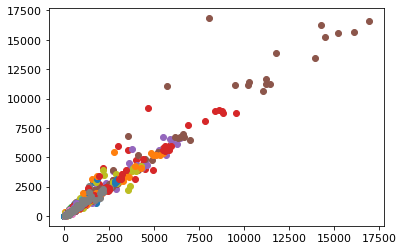

In [22]:
for i in range(n.shape[1]):
    plt.scatter(n[:,i], y_test_eval[:,i])

In [17]:
n,v,l = util_gat.testset_output_gat(testloader, args.MeanOnly, net, criterion, 
            adj_torch, spatial_torch, device, n_time, return_components=False)

In [20]:
n

array([[1047.2805  , 1227.244   ,  262.98868 , ...,  212.05145 ,
         305.73636 , 1037.9435  ],
       [ 323.1725  ,  636.58044 ,   62.38707 , ...,   88.79664 ,
         157.3876  ,  564.38605 ],
       [ 138.26692 ,  552.42914 ,   28.509754, ...,   58.189297,
         114.86733 ,  328.26794 ],
       ...,
       [  99.42861 ,  243.3134  ,   33.82699 , ...,   66.206085,
          95.19356 ,  237.17813 ],
       [  82.679214,  293.60922 ,   37.10621 , ...,   48.63967 ,
         128.46245 ,  193.68794 ],
       [  64.36898 ,  132.66673 ,   13.170844, ...,   31.655338,
         130.56206 ,  126.03638 ]], dtype=float32)

In [118]:
me = a[0]

mv = a[1]

for i in me:
    print(torch.mean(i))

for i in mv:
    print(torch.mean(i))

tensor(2.5527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(553.6168, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1865, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.7955, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(470.9042, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1877, device='cuda:0', grad_fn=<MeanBackward0>)


In [26]:
print(np.mean(y_test_eval))

635.3980952380953


In [16]:
metrics_dict
###laplace

{'loss_train': 106.41467970244739,
 'mae_train': 96.0636896531218,
 'mse_train': 139864.90063999864,
 'mpiw_train': 798.1303300476741,
 'picp_train': 0.9520443594104309,
 'loss_val': 94.3471960308908,
 'mae_val': 53.65683857356299,
 'mse_val': 16336.757917356099,
 'mpiw_val': 565.6342093650294,
 'picp_val': 0.9683908045977011,
 'loss_test': 102.06424107142857,
 'mae_test': 71.94507209232876,
 'mse_test': 77959.43507621683,
 'mpiw_test': 784.5651938885308,
 'picp_test': 0.979047619047619}

In [74]:
tr_loss, tr_mae, tr_mse, tr_mpiw, tr_picp,a,b = evaluate(args, dist, trainloader_test, z, y_train_eval)


9.599216 9.358207 153.0 -120.56051
9775.662 9007.536 17022.0 -10.348346
14.885377 14.06475 84.0 -15.636463
138.39621 139.9595 810.0 -17.37337
61.679 62.289394 582.0 -39.939404
36.556564 33.937904 180.0 -13.3757305
0.74167854 0.6698606 101.0 -11201.138
67.39761 62.434994 633.0 -46.086357
32.52481 31.359903 3235.0 -5218.617
8.196163 8.009412 105.0 -76.0384
9.561639 9.207273 90.0 -41.301224
2.3692436 2.043839 15.0 -20.72946
68.91105 63.856094 509.0 -28.82462
2.353861 2.069154 18.0 -30.235064
12.654346 12.0952635 154.0 -71.69345
12.490443 12.029761 98.0 -28.669342
3.306565 2.9618487 16.0 -11.188133
0.7207594 0.6875997 178.0 -33236.973
24.641361 23.744886 130.0 -13.930272
31.503342 30.246819 305.0 -45.208675
686.5733 632.61115 8616.0 -85.92489
9447.265 8704.958 17268.0 -10.394168
759.2768 700.059 3669.0 -16.107922
14.337747 14.075638 477.0 -543.77264
0.68642956 0.8748518 447.0 -130131.91
26.839603 25.831547 152.0 -15.908777
17.56476 16.773191 101.0 -16.110655
139.95982 129.52791 578.0 -11.5

In [67]:
test_loss, test_mae, test_mse, test_mpiw, test_picp,_,_ = evaluate(args, dist, testloader, z, y_test_eval)


tensor(1.1132, device='cuda:0', grad_fn=<SelectBackward0>) tensor(326., device='cuda:0') tensor(-19822.9180, device='cuda:0', grad_fn=<SelectBackward0>)
